# Proxy for the Mtm of swaps :

In [1]:
project_path = r'C:\Users\omirinioui\PycharmProjects\Projet Quadrature bayésienne'

In [2]:
lib_path = project_path+'\libraries'
port_path = project_path + '\Data\portfolio'
zc_curve_path = project_path+'\Data\ZC Curve'
diff_path = project_path + '\Data\Diffusion'
MC_path =  project_path +'\Results\Full MC'
img_path = project_path +'\Results\Images'


In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import pandas as pd

import  numpy as np

from time import time
from datetime import timedelta

# importing pacakge 
import sys         
sys.path.append(lib_path)        

from main import *
from FinancialData import *
from Chebychev import *

In [4]:
def GPR_Mtm_ploter(t, diff, irs, ZC, nodes_nbr, diag=False) :
    train_range = (min(diff.X(t)) , max(diff.X(t)) )

    # Pricing to train
    train_points = np.linspace(train_range[0], train_range[1], nodes_nbr)
    mtm_points = irs.Mtm_mono(t,train_points,ZC,diff.get_LGM_params())

    # Train
    gpr_model = GaussianProcessRegressor(kernel = kernel, normalize_y=True)
    gpr_model.fit(train_points.reshape(nodes_nbr,1), mtm_points.reshape(nodes_nbr,1))


    # Mtm Proxy
    Mtm = gpr_predictor(gpr_model, np.sort(diff.X(t)).reshape(diff.nbr_scenarios,1))
    Mtm_true = irs.Mtm_mono(t, np.sort(diff.X(t)),ZC,diff.get_LGM_params())
    
    if diag :
        plt.plot(Mtm_true,  Mtm_true, c = 'red', label = 'true')
        plt.scatter(Mtm_true, Mtm.reshape(diff.nbr_scenarios), label ='GPR')

        plt.xlabel('True Mtm', fontsize = 15)   
        plt.ylabel('GPR', fontsize = 15) 
        plt.legend()
        plt.title(str(nodes_nbr)+' training points', fontdict = {'fontsize':16})
        plt.show()
    else :  
        N = 400
        x_range = np.linspace(train_range[0], train_range[1], N)
        plt.plot(x_range, irs.Mtm_mono(t, x_range,ZC,diff.get_LGM_params()) , label='True')

        plt.scatter(train_points,mtm_points,c='r')

        plt.plot(np.sort(diff.X(t)) , Mtm.reshape(diff.nbr_scenarios) , label='GPR')

        plt.legend()
        plt.xlabel('$X_{t}$')
        plt.ylabel(' Mark-to-Market')
        plt.title(str(nodes_nbr) + ' training points' )
        plt.show()

def Chebyshev_Mtm_ploter(t, diff, irs, ZC, nodes_nbr,diag=False) :
    train_range = (min(diff.X(t)) , max(diff.X(t)) )

    # Pricing to train
    train_points = np.sort(Chebyshev_points(train_range[0], train_range[1], nodes_nbr))
    mtm_points = irs.Mtm_mono(t,train_points,ZC,diff.get_LGM_params())


    # Mtm Proxy
    Mtm = np.array([eval_Barycentric(mtm_points, train_points, x) for x in np.sort(diff.X(t))])
    Mtm_true = irs.Mtm_mono(t, np.sort(diff.X(t)),ZC,diff.get_LGM_params())
    
    if diag :
        plt.plot(Mtm_true,  Mtm_true, c = 'red', label = 'true')
        plt.scatter(Mtm_true, Mtm, label ='Chebyshev')

        plt.xlabel('True Mtm', fontsize = 15)   
        plt.ylabel('Chebyshev', fontsize = 15) 
        plt.legend()
        plt.title(str(nodes_nbr)+' training points', fontdict = {'fontsize':16})
        plt.show()
        
    else :  
        N = 400
        x_range = np.linspace(train_range[0], train_range[1], N)
        plt.plot(x_range, irs.Mtm_mono(t, x_range,ZC,diff.get_LGM_params()) , label='true')

        plt.scatter(train_points,mtm_points,c='r')
        plt.plot(np.sort(diff.X(t)) , Mtm , label='Chebyshev')

        plt.legend()
        plt.xlabel('$X_{t}$')
        plt.ylabel(' Mark-to-Market')
        plt.title(str(nodes_nbr) + ' training points' )
        plt.show()

def Chebyshev_Mtm(t, diff, irs, ZC, nodes_nbr) :
    train_range = (min(diff.X(t)) , max(diff.X(t)) )

    # Pricing to train
    train_points = np.sort(Chebyshev_points(train_range[0], train_range[1], nodes_nbr))
    mtm_points = irs.Mtm_mono(t,train_points,ZC,diff.get_LGM_params())


    # Mtm Proxy
    Mtm = np.array([eval_Barycentric(mtm_points, train_points, x) for x in np.sort(diff.X(t))])
    Mtm_true = irs.Mtm_mono(t, np.sort(diff.X(t)),ZC,diff.get_LGM_params())
    
    return Mtm

def GPR_Mtm(t, diff, irs, ZC, nodes_nbr, diag=False) :
    train_range = (min(diff.X(t)) , max(diff.X(t)) )

    # Pricing to train
    train_points = np.linspace(train_range[0], train_range[1], nodes_nbr)
    mtm_points = irs.Mtm_mono(t,train_points,ZC,diff.get_LGM_params())
    
    if (mtm_points == np.zeros(nodes_nbr) ).all():
        return 0

    # Train
    gpr_model = GaussianProcessRegressor(kernel = kernel, normalize_y=True)
    gpr_model.fit(train_points.reshape(nodes_nbr,1), mtm_points.reshape(nodes_nbr,1))


    # Mtm Proxy
    Mtm = gpr_predictor(gpr_model, np.sort(diff.X(t)).reshape(diff.nbr_scenarios,1))
    
    return Mtm.reshape(diff.nbr_scenarios)





In [5]:
ZCR = ZC_Data_extractor(zc_curve_path)    
ZC = zero_coupon_bonds(ZCR, 3) # We chose 3 as degree of the Spline Interpolation 

#load portfolio data
with open(port_path+'\port400irs1fx', 'rb') as f1:
    portfolio = pickle.load(f1)
    
# Set Maturity     
T = portfolio.last_maturity

#load diffusion data
with open(diff_path+'\MC60000p400swap1fx', 'rb') as f1:
    diff = pickle.load(f1)

In [6]:
#LGM params
sig = 0.005 
lam = 0.01


## 1. Gaussian proxy for the Mtm of a swap portfolio

The implemented formulas are derived from LGM 1F using a 1st order Taylor approximation with respect to $X_{t}$ in the reconstruction formula under the terminal probability measure $\mathbb{Q}_{t}$

In [7]:
def quad_norm(x) :
    return np.sum(np.sqrt(x))**2

def beta(t,T,lam):
    return (1 - np.exp(-lam * (T - t))) / lam

def A(t,T,lam, sig, ZC): 
    zcb_t, zcb_T=  ZC.initial_zcb_curve(t) , ZC.initial_zcb_curve(T)
    beta_ = beta(t,T,lam)
    phi = (sig ** 2 ) * (1 - np.exp(-2 * lam * t)) / (2 * lam)
    
    return (zcb_T / zcb_t) * np.exp(-0.5 * beta_ ** 2 * phi)
    
def zcb_law_lgm(t,T,lam,sig,ZC) :
    mu_X_t = 0
    std_X_t = sig * np.sqrt( (1 - np.exp(-2 * lam *t )) / (2 *lam) )
    
    mean = A(t,T,lam,sig,ZC) * ( 1 - beta(t,T,lam) * mu_X_t)
    std = std_X_t *A(t,T,lam,sig,ZC) * beta(t,T,lam)
    
    return mean, std


def swap_law(t,swap, lam, sig,ZC) :
    mu_X_t = 0
    std_X_t = sig * np.sqrt( (1 - np.exp(-2 * lam *t )) / (2 *lam) )
    if  swap.tenor[-2] < t:
        return 0,0
    else :
        swap_type = (swap.exercice == "payer") * 2 - 1
        maturities = swap.tenor[(swap.tenor < t).sum():]
        

        deltaK = np.zeros(maturities.shape[0])
        coef = np.zeros(maturities.shape[0])

        coef[0] = 1
        coef[-1] = -1

        deltaK[1:] = np.diff(maturities)*swap.strike

        coef = coef - deltaK

        A_ = A(t,maturities,lam, sig, ZC)
        M = A_*beta(t,maturities,lam)

        mean  = swap_type*swap.nominal*(np.dot(coef,A_) - np.dot(coef,M)*mu_X_t)

        std = swap.nominal*np.dot(coef,M)*std_X_t

        return mean , std

def Mtm_proxy_law(t, portfolio, lam, sig, ZC):
    swaps_law = np.array([ swap_law(t,swap, lam, sig,ZC) for swap in portfolio.swaps]) 
    mean_swaps = swaps_law[:,0]
    std_swaps = swaps_law[:,1]
    
    var = quad_norm(std_swaps**2)
    mean = np.sum(mean_swaps)
    
    return mean , np.sqrt(var)

def Mtm_proxy(t, portfolio, lam, sig, ZC):
    mu_X_t = 0
    std_X_t = sig * np.sqrt( (1 - np.exp(-2 * lam *t )) / (2 *lam) )
    
    swaps_law = np.array([ swap_law(t,swap, lam, sig,ZC) for swap in portfolio.swaps]) 
    mean_swaps = swaps_law[:,0]
    std_swaps = swaps_law[:,1]
    
    var = quad_norm(std_swaps**2)
    mean = np.sum(mean_swaps)
    
    
    
    
    return mean , np.sqrt(var)/std_X_t

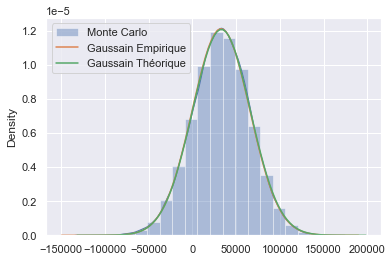

In [8]:

irs = portfolio

t = 4

Vt=irs.Mtm(t,diff,ZC)

sns.distplot(Vt, hist = True, bins=20, kde = True, kde_kws={ 'linewidth': 1}, label ='Monte Carlo')
# Plot the PDF.
xmin, xmax = plt.xlim()
ax = np.linspace(xmin, xmax, 100)
p = norm.pdf(ax, np.mean(Vt) ,  np.std(Vt))
m,s = Mtm_proxy_law(t,irs, lam, sig,ZC)

x_, x__ = m-5*s , m+5*s
ax_ = np.linspace(x_, x__, 100)

pt =  norm.pdf(ax_, m,s)
plt.plot(ax,p,label='Gaussain Empirique')
plt.plot(ax_,pt,label='Gaussain Théorique')

plt.legend()
plt.show()

In [9]:
 np.mean(Vt) ,  np.std(Vt)

(32779.15333610029, 32930.62363893174)

In [10]:
 Mtm_proxy_law(t,irs, lam, sig,ZC)

(33178.64646149106, 33041.097266135395)

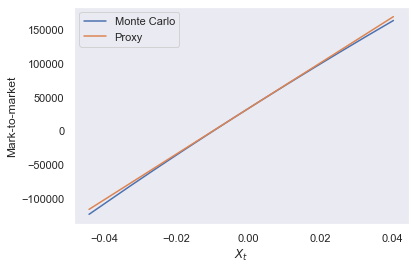

In [11]:
t = 4
Xt = np.sort(diff.X(t))
Mtm_t = irs.Mtm_mono(t,Xt,ZC,diff.get_LGM_params())

a,b =  Mtm_proxy(t, portfolio, lam, sig, ZC)

plt.plot(Xt, Mtm_t,label='Monte Carlo' )
plt.plot(Xt , a+b*Xt , label='Proxy')
plt.xlabel('$X_{t}$')
plt.ylabel('Mark-to-market')
plt.grid(False)
plt.legend()

#### Using now swap proxy dynamic ( A titre illustrative )

In [12]:
def level(t,swap, diff,ZC):
    return (np.diff(swap.tenor)*diff.ZCB(t,swap.tenor,ZC)[:,1:]).sum(axis=1)
def level_initial(swap,ZC):
    zcb = ZC.initial_zcb_curve(swap.tenor)
    return ((swap.tenor[1:] - swap.tenor[:-1]) * zcb[1:]).sum()

def level_proxy(t,T,s0):
    return (1-np.exp(-s0*(T-t)))/s0
def sigma_bachelier(expiry,swap,sigma,lam,ZC):
    zeroCoupon = lambda t : ZC.initial_zcb_curve(t)

    t_start = swap.tenor[0]
    t_end = swap.tenor[-1]

    level = 0
    level_exp = 0

    for tenor in swap.tenor[1:]:
        level += swap.freq * zeroCoupon(tenor)
        level_exp += swap.freq * zeroCoupon(tenor) * np.exp(-lam * tenor)

    s0 = (zeroCoupon(t_start) - zeroCoupon(t_end)) / level
    g0 = (zeroCoupon(t_start) * np.exp(-lam * t_start) - zeroCoupon(t_end) * np.exp(-lam * t_end)) / (
            zeroCoupon(t_start) - zeroCoupon(t_end)) - level_exp / level
    g0 /= lam

    sigma_etoile = sigma ** 2 * s0**2 * g0 ** 2 * (np.exp(2 * lam * expiry) - 1) / (2 * lam)
    sigma_etoile = np.sqrt(sigma_etoile)
    
    return sigma_etoile
def proxy2_level(t,swap, diff,ZC):
    zcb = diff.ZCB(t,swap.tenor,ZC)
    St=(zcb[:,0] - zcb[:,-1]) / ((swap.tenor[1:] - swap.tenor[:-1]) * zcb[:,1:]).sum()
    T = swap.tenor[-1]
    return ((1-np.exp(-St*(T-t)))/St)


In [13]:
#Let's start for one swap

swaps =  [ (IrsPortfolio(1 , first_date=[0], freq=[0.25, 0.5, 1], Nominal=[10000],
                 maturity=[T],
                 fix_rate=[0.02, 0.05], exercice=['payer'], SEED=1999).swaps)[0] for T in ZCR['Time'].values]


In [14]:
df =pd.DataFrame(columns=['Maturities' , 'Swap Rate', 'Level', 'Proxy Level'])

In [15]:
df['Maturities'] = ZCR['Time'].round(2)
df['Swap Rate'] = np.array([ swap.swap_rate(ZC) for swap in swaps])
df['Level'] = np.array([ level_initial(swap,ZC) for swap in swaps])
df['Proxy Level'] = level_proxy(0, df['Maturities'], df['Swap Rate'] )
df.round(3)

,Maturities,Swap Rate,Level,Proxy Level
0,0.00,0.026,0.248,0.000
1,0.08,0.026,0.248,0.080
2,0.50,0.023,0.496,0.497
3,1.00,0.023,0.986,0.989
4,2.00,0.024,1.948,1.953
5,3.00,0.027,2.883,2.883
6,4.00,0.029,3.785,3.775
7,5.00,0.032,4.652,4.625
8,6.00,0.034,5.482,5.433
9,7.00,0.036,6.273,6.196


In [16]:
t=5
dft= df
dft['Level mean'] = np.array([ np.mean(level(t,swap, diff,ZC)) for swap in swaps])
dft['Level std'] = np.array([ np.std(level(t,swap, diff,ZC)) for swap in swaps])

dft.round(3)

,Maturities,Swap Rate,Level,Proxy Level,Level mean,Level std
0,0.00,0.026,0.248,0.000,0.291,0.015
1,0.08,0.026,0.248,0.080,0.291,0.015
2,0.50,0.023,0.496,0.497,0.581,0.030
3,1.00,0.023,0.986,0.989,1.155,0.056
4,2.00,0.024,1.948,1.953,2.283,0.098
5,3.00,0.027,2.883,2.883,3.380,0.127
6,4.00,0.029,3.785,3.775,4.437,0.143
7,5.00,0.032,4.652,4.625,5.453,0.147
8,6.00,0.034,5.482,5.433,6.426,0.141
9,7.00,0.036,6.273,6.196,7.353,0.125


In [17]:
def proxy_law(t,irs, lam, sig,ZC): 
    swap = irs.swaps[0]
    s0 = swap.swap_rate(ZC)
    mean = swap.nominal * level_proxy(t,swap.tenor[-1],s0) * (s0-swap.strike)
    
    std = swap.nominal*level_proxy(t,swap.tenor[-1],s0)*sigma_bachelier(t,swap,sig,lam,ZC)
    return mean,std

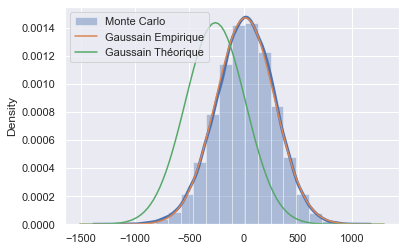

In [18]:
# The swap object 

irs =  IrsPortfolio(1 , first_date=[0], freq=[0.25, 0.5, 1], Nominal=[10000],
                 maturity=[T],
                 fix_rate=[0.02, 0.05], exercice=['payer'], SEED=1999)


t=4
Vt=irs.Mtm(t,diff,ZC)


sns.distplot(Vt, hist = True, bins=20, kde = True, kde_kws={ 'linewidth': 3}, label ='Monte Carlo')
# Plot the PDF.
xmin, xmax = plt.xlim()
ax = np.linspace(xmin, xmax, 100)
p = norm.pdf(ax, np.mean(Vt) ,  np.std(Vt))
m,s = proxy_law(t,irs, lam, sig,ZC)
pt =  norm.pdf(ax, m,s)
plt.plot(ax,p,label='Gaussain Empirique')
plt.plot(ax,pt,label='Gaussain Théorique')

plt.legend()
plt.show()

## 2. Calcul de EE et CVA avec le proxy gaussien : 

In [19]:
def Expected_exposure_proxy(t, portfolio, lam, sig, ZC) :
    mu , sigma = Mtm_proxy_law(t, portfolio, lam, sig, ZC)
    if sigma == 0:
        return 0
    return ZC.initial_zcb_curve(t)*(mu*norm.cdf(mu/sigma) + sigma*norm.pdf(mu/sigma))
    

In [20]:
#recovery rate & defult probability parameter :
R, lamda = 0.4, 0.005

Calulcaltion for 50 is Done ------
Calulcaltion for 100 is Done ------
Calulcaltion for 300 is Done ------
Calulcaltion for 500 is Done ------
Calulcaltion for 700 is Done ------
Calulcaltion for 800 is Done ------
Calulcaltion for 900 is Done ------
Calulcaltion for 1000 is Done ------
Total Calculation Time : 0:02:05


,Discretization,CVA,Computation Time
0,50.0,440.35,1.56
1,100.0,433.92,2.89
2,300.0,435.49,8.49
3,500.0,435.67,13.16
4,700.0,436.00,18.37
5,800.0,435.42,21.17
6,900.0,435.64,29.49
7,1000.0,435.59,30.22


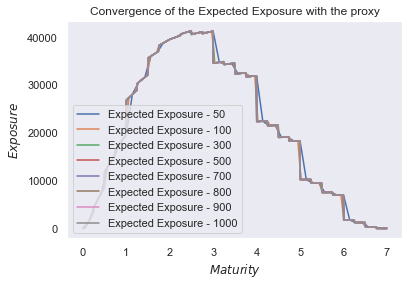

In [21]:

discretisations =[50,100,300,500,700,800,900,1000]

cva_integration =  pd.DataFrame(columns=['Discretization', 'CVA' , 'Computation Time'])

start = time()
for n in discretisations :
    time_grid = np.linspace(0,T,n)
    
    mc_start = time()
    
    EE =np.array([ Expected_exposure_proxy(t, portfolio, lam, sig, ZC)  if 0<t and t<T else 0 for t in time_grid])
    PD = np.array([ lamda * np.exp(-lamda *t) for t in time_grid])
    Y = (1-R)*EE*PD
    cva = (np.diff(time_grid)*Y[1:]).sum()
    
    cva_integration.loc[len(cva_integration)] = [ round(n) , cva, time() - mc_start]
    
   
    plt.plot(time_grid, EE, label="Expected Exposure - "+str(n))
    plt.legend()
    plt.xlabel(r"$Maturity$")
    plt.ylabel(r"$Exposure$")
    plt.grid(False)
    plt.title("Convergence of the Expected Exposure with the proxy")
    
    print('Calulcaltion for '+str(n)+' is Done ------')

    
print('Total Calculation Time :' , "{}".format(str( timedelta( seconds=round(time()-start) ) )))
cva_integration.round(2)

on affiche cette figure à titre indicatif et à ne pas inclure dans le papier 

In [22]:
cva_integration.astype(int)

,Discretization,CVA,Computation Time
0,50,440,1
1,100,433,2
2,300,435,8
3,500,435,13
4,700,436,18
5,800,435,21
6,900,435,29
7,1000,435,30


In [23]:
cva_integration.astype(int).to_latex(
    index=False,  # To not include the DataFrame index as a column in the table
    caption="Convergence of the expected exposure based on closed formula using a gaussian proxy ",  # The caption to appear above the table in the LaTeX document  # A label used for referencing the table within the LaTeX document
    position="htbp",  # The preferred positions where the table should be placed in the document ('here', 'top', 'bottom', 'page')
    column_format="|l|l|l|l|",  # The format of the columns: left-aligned with vertical lines between them
    escape=False,  # Disable escaping LaTeX special characters in the DataFrame
)

'\\begin{table}[htbp]\n\\caption{Convergence of the expected exposure based on closed formula using a gaussian proxy }\n\\begin{tabular}{|l|l|l|l|}\n\\toprule\nDiscretization & CVA & Computation Time \\\\\n\\midrule\n50 & 440 & 1 \\\\\n100 & 433 & 2 \\\\\n300 & 435 & 8 \\\\\n500 & 435 & 13 \\\\\n700 & 436 & 18 \\\\\n800 & 435 & 21 \\\\\n900 & 435 & 29 \\\\\n1000 & 435 & 30 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

On converge très rapidement en s  avec 500 discrétisation et vers 435 euro 

### Profil EE pour les 3 méthodes  : MC , Intégration numérique et proxy

In [38]:
lgm_params = diff.get_LGM_params()

In [39]:
def Expected_exposure_benchmark(t, portfolio, ZC,lgm_params , n_std, n_reim) : 
    lam,sig = lgm_params
    mu_X_t = 0
    std_X_t =sig * np.sqrt( (1 - np.exp(-2 * lam *t )) / (2 * lam) )

    train_range = ( mu_X_t-n_std*std_X_t, mu_X_t+n_std*std_X_t )

    # Pricing 
    X = np.linspace(train_range[0], train_range[1], n_reim)
    mtm = portfolio.Mtm_mono(t,X,ZC,lgm_params)

    Y = np.maximum(mtm, 0)*norm.pdf(X, mu_X_t, std_X_t)

    return ZC.initial_zcb_curve(t) * (np.diff(X)*Y[1:]).sum()

In [40]:
with open(MC_path +'\EE_MC_converged60000_P400swapfX1' ,'rb') as f:
    EE_MC= pickle.load(f)

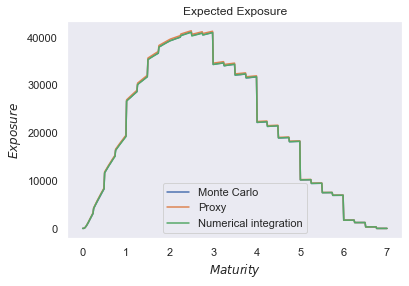

In [42]:
time_grid = np.linspace(0,T,500)
n_std , integ_pts = 5, 300

#Proxy
EE =np.array([ Expected_exposure_proxy(t, portfolio, lam, sig, ZC)  if 0<t and t<T else 0 for t in time_grid])
PD = np.array([ lamda * np.exp(-lamda *t) for t in time_grid])
Y = (1-R)*EE*PD
cva_proxy = (np.diff(time_grid)*Y[1:]).sum()

#Numerical integration 
EE_integ =np.array([ Expected_exposure_benchmark(t, portfolio, ZC, lgm_params , n_std, integ_pts)  if 0<t and t<T else 0 for t in time_grid])

cva_integ = (np.diff(time_grid)*((1-R)*EE_integ*PD)[1:]).sum()


plt.plot(time_grid, EE_MC, label="Monte Carlo" )
plt.plot(time_grid, EE, label="Proxy")
plt.plot(time_grid, EE_integ, label="Numerical integration" )

plt.legend()
plt.xlabel(r"$Maturity$")
plt.ylabel(r"$Exposure$")
plt.title("Expected Exposure")
plt.grid(False)
